Exception in thread Thread-12 (read_uart):
Traceback (most recent call last):
  File "D:\Anaconda\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "D:\Anaconda\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\romai\Documents\18F4550\Nuclear-Disintegration AppDev\pythonApp\modules\terminalUART.py", line 66, in read_uart
    if self.serial_port and self.serial_port.in_waiting > 0:
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Anaconda\Lib\site-packages\serial\serialwin32.py", line 259, in in_waiting
    raise SerialException("ClearCommError failed ({!r})".format(ctypes.WinError()))
serial.serialutil.SerialException: ClearCommError failed (PermissionError(13, 'Accès refusé.', None, 5))


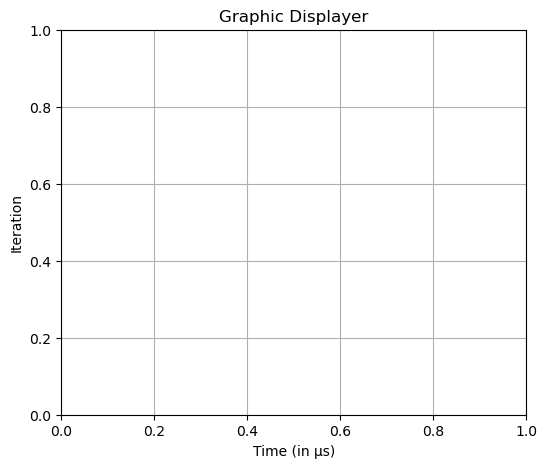

In [11]:
# Modules imports
from modules.fileManaging import exit, open_file, plot_data
from modules.fitFunctions import add_erlang_fit, add_poisson_fit, add_gaussian_fit
from modules.objectCreator import *
from modules.terminalUART import *
from modules.commandPIC18F import setFactorK
# General libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import csv
from collections import defaultdict
import tkinter
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import *
import math
from scipy.stats import poisson
from tkinter import messagebox

# Screen
analysis = tkinter.Tk() # Définition d'un écran
analysis.geometry("1280x720") # Définition de la taille de l'écran
analysis.title("Desintegrations Nucleaires") # Définition du nom de l'application

# Titre de l'application
title = Label(text="Distribution de Poisson/Erlang", font=("Arial", 16, "bold")) # Définition du titre
title.pack() # Affichage du label

# Définition du canvas initial
canvas_width = 1280
canvas_height = 720
canvas = tkinter.Canvas(analysis, width=canvas_width, height=canvas_height, bg='white')
canvas.pack()

# Créer le graphique initial
fig, ax = createGraph(0, 20, canvas, analysis)


# Définition des variables globales
data = defaultdict(list) # Liste de données pour la lecture du fichier csv
user_input = 0 # Fréquence du signal pour l'adaptation de l'échelle des abscisses
selected_value = tkinter.IntVar()  # Variable k
selected_value.set(1) # Valeur par défaut

# Créer et place le terminal UART
terminal = UARTTerminal(analysis)
#terminal.pack(side='top', anchor='ne', expand=True, fill='both')
terminal.place(x=650, y=100, width=600, height=500)

# Définir la fonction de fermeture
analysis.protocol("WM_DELETE_WINDOW", lambda: on_closing(analysis, terminal))


############################## Définition des fonction principales ##############################

# Fonction pour gérer l'appel à open_file et récupérer les données
def load_file():
    global data
    data = open_file(canvas, ax, user_input) # Récupération des données lues par la fonction open_file
    if data is not None: # Verification du chargement des données
        print("Data loaded successfully")
    else:
        print("No data loaded")

# Fonction pour enregistrer la valeur user_input utilisée pour le facteur k
def show_entry_value():
    try:
        global user_input
        # Récupérer la valeur saisie et la convertir en entier
        user_input = int(entry.get())
        # Envoyer la valeur saisie au PIC18F4550
        setFactorK(user_input)
        # Afficher la valeur saisie dans une boîte de message
        messagebox.showinfo("Information", f"Vous avez saisi : {user_input}")
        # Vous pouvez également utiliser la valeur ici pour d'autres opérations
        print(f"Valeur saisie : {user_input}")
    except ValueError:
        # Afficher un message d'erreur si la saisie n'est pas un entier
        messagebox.showerror("Erreur", "Veuillez entrer un entier valide.")
        entry.delete(0, tk.END)
        entry.insert(0, "0")  # Réinitialiser à une valeur par défaut  

def on_connect():
    terminal.connect() # On se connecte au port série
    container.update_buttons_state() # Si le terminal est bien connecté, on rend utilisable les boutons de contrôle
    terminal.send_data('?') # On demande l'état actuel du PIC (Le premier char est toujours ignoré, je ne sais pas pourquoi)
    terminal.send_data('?')
        
# Fonction de fermeture du terminal
def on_closing(root, terminal):
    terminal.close()
    root.destroy()

############################## Configuration des boutons et menus ##############################

# Créer une instance du conteneur personnalisé et l'ajouter à la fenêtre principale
container = controlPIC(analysis, terminal)
container.place(x=350,y=550)
#container.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

# Bouton de connexion
connect_button = Button(analysis, text="Connecter", command=on_connect)
connect_button.place(x=650, y=600)

# Bouton pour charger un fichier CSV
b1 = Button(text="Load CSV", command=load_file) # Bouton pour sélectionner et afficher des données
b1.place(x=60,y=600)

# Bouton pour quitter l'application (non fonctionnel pour le moment)
bclose = Button(text="Close Application", command=(exit)) # Bouton pour fermer l'application
bclose.place(x=1150,y=670)

# Label pour le titre du terminal
labelUART = tkinter.Label(analysis, text="UART Terminal", font=("Arial", 16, "bold"), fg="blue", relief="raised")
labelUART.place(x=870, y=60)

# Label pour le choix de fréquence
labelfreq = tkinter.Label(analysis, text="Enter frequency value :")
labelfreq.place(x=60, y=630)

# Ajouter une zone de texte (Entry)
entry = tkinter.Entry(analysis, width=20)
entry.place(x=60, y=655)
entry.insert(0, 0)

# Ajouter un bouton pour récupérer la valeur saisie
button_confirm = tkinter.Button(analysis, text="Confirm", command=show_entry_value)
button_confirm.place(x=60, y=675)


# Menu déroulant pour la sélection du facteur k

#options = list(range(1, 10)) # Definition de la liste d'options
#selected_value = tkinter.IntVar() # Declaration de la variable de selection
#selected_value.set(options[0])  # Sélectionne la première option par défaut
#option_menu = tkinter.OptionMenu(analysis, selected_value, *options) # Definition du menu sur le screen
#option_menu.place(x=255,y=595) # Position du menu
#l2 = Label(text="k Factor") # Définition du titre
#l2.place(x=200,y=600) # Affichage du label

# Bouton pour tracer l'Exponentielle
button_exp = Button(text="Add Exponential Fit", command=lambda: add_erlang_fit(data, canvas, ax, selected_value, user_input))
button_exp.place(x=200,y=630)

# Bouton pour tracer la Gaussienne
button_gaussian = tkinter.Button(analysis, text="Add Gaussian Fit", command=lambda: add_gaussian_fit(data, canvas, ax, user_input))
button_gaussian.place(x=200,y=660)

# Bouton pour tracer Poisson
button_poisson = tkinter.Button(analysis, text="Add Poisson Fit", command=lambda: add_poisson_fit(data, canvas, ax, user_input))
button_poisson.place(x=200,y=690)






# Loop
analysis.mainloop() # Pour maintenir l'application ouverte
